In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.stats import truncnorm

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm
import time
import pdb
import argparse
import sys
from shapes_loader import *
from base_model import *
import tf_homo

DEVICE = 'cuda'

In [13]:
# parameter 
threshold = 0.3

# load in model
magic_leap_model = SuperPointNet().to(DEVICE)
model = torch.load('./Fri Nov  9 15:54:21 2018/e_405_a_10.9042.model').to(DEVICE)
magic_leap_model.load_state_dict(torch.load('superpoint_v1.pth'))
criterion = nn.Softmax(dim=1) #reduction='elementwise_sum')

# load in images
img_dir = '../test_coco/'
imgsList = os.listdir(img_dir)
clr_imgs = [Image.open(img_dir+img).resize((400,300),Image.ANTIALIAS) for img in imgsList]
imgs = torch.tensor(np.asarray([np.array(Image.open(img_dir+img).resize((400,300),Image.ANTIALIAS).convert('L')) for img in imgsList], dtype='float')).to(DEVICE)  

image = imgs[0:3] # 3 x h x w = 3x300x400
net = model
config = {}
config['aggregation'] = 'max' # 'min'
config['num'] = 100 # how many homography adaptation to perform per image
config['patch_ratio'] = 0.85

In [16]:
#tf_homo.homography_adaptation(image.float().unsqueeze(1),net,tf_homo.homography_adaptation_default_config)

image tensor([300., 400.])
patch output torch.Size([1, 65, 37, 50])
counts shape: torch.Size([1, 65, 37, 50, 1])
resize count: torch.Size([37, 50])
counts torch.Size([1, 65, 37, 50, 1])
probs torch.Size([1, 65, 37, 50, 1])


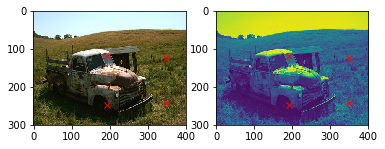

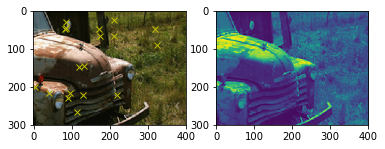

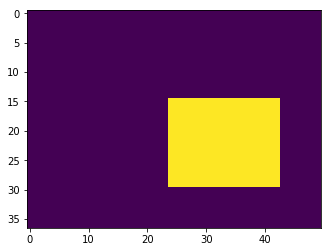

In [19]:
#def homography_adaptation(image, net, config):

####### TEST ON ONE IMAGE: #######

# PIL color image & torch grayscale image
test = clr_imgs[0] 
image = torch.from_numpy(np.array(test.convert('L')))
# get the shape
shape = torch.Tensor([image.shape[0], image.shape[1]]).type(torch.FloatTensor)
print('image', shape)
# inference on original image
probs, _ = net(image.float().unsqueeze(0).unsqueeze(1).to(DEVICE))
# global variable for aggregation, will be concat at last dimension
counts = torch.ones(probs.shape)
probs = probs.unsqueeze(-1)
counts = counts.unsqueeze(-1)
images = image.unsqueeze(-1)
#
# sample one homography
# We should sample config['num'] times
H, patch = sample_homography(shape) # H*[w;h;1] = [_;_;_] is a coner of the patch
inv_H = invert_homography(H)
# the patch corners
px = patch[:,0].numpy()
py = patch[:,1].numpy()
# get in numpy
test_H = H[0].numpy()
test_inv_H = inv_H[0].numpy()
# apply homography on color scale and grayscale
test_warped = test.transform(size=test.size, method=Image.PERSPECTIVE, data=test_H, resample=Image.BILINEAR)
image_warped = torch.tensor(np.array(test_warped.convert('L'), dtype='float'))
# show original image
fig=plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(clr_imgs[0]) # color
plt.plot(px,py,'xr')
fig.add_subplot(1, 2, 2)
plt.imshow(image) # gray
plt.plot(px,py,'xr')
# show warped image
fig=plt.figure()
fig.add_subplot(1, 2, 2)
plt.imshow(image_warped) # gray
fig.add_subplot(1, 2, 1)
plt.imshow(test_warped) # color
# inference on the warped image
ipt_patch, _ = net(image_warped.unsqueeze(0).unsqueeze(1).float().to(DEVICE))
print('patch output',ipt_patch.shape)

# want to look at points extracted on warped image
ipt_sm_patch = criterion(ipt_patch)
ipt_sm_patch = ipt_sm_patch[:,:-1,:,:]
idx_conf_patch, idx_locs_patch = ipt_sm_patch.max(dim=1)
idx_mask_patch = idx_conf_patch > threshold
# plot the points on the warped image
px = []
py = []
_, _, hc, wc = ipt_patch.shape
for x in range(hc):
    for y in range(wc):
        if idx_mask_patch[0,x,y] == 1:
            #location in the image
            x_ = x*8 +(idx_locs_patch[0,x,y]/8)
            y_ = y*8 + (idx_locs_patch[0,x,y]%8)
            px.append(x_.item())
            py.append(y_.item())
plt.plot(py,px,'xy')

# aggregate the probablities::: Here the trouble comes:
# The prob from inference on the warped image, doesn't 
# represent the same area as in the original image. A warping is needed.
# The warping works on the size of the image => H warps [0,300,1] to a corner of the patch
# The warping works on the size of the image => inv_H warps a corner of the patch to [0,300,1]
# However, prob have 1 x 65 x 37 x 50. How to warp it to the correct area?

print('counts shape:',counts.shape)
# warp the mask to correct
count = Image.new("L", test.size, "white").transform(size=test.size, method=Image.PERSPECTIVE, data=test_inv_H, resample=Image.NEAREST)
count = count.resize((50,37))
count = torch.from_numpy(np.array(count)).type(torch.FloatTensor)#.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
print('resize count:',count.shape)
# show mask
fig=plt.figure()
plt.imshow(count)
# aggregate

##
## TODO
##

#counts = torch.cat((counts,count),dim=-1)

# After aggregation 
### TODO
print('counts',counts.shape)
print('probs',probs.shape)
counts = torch.sum(counts, dim=-1).to(DEVICE)
max_prob = torch.max(probs, dim=-1)
mean_prob = torch.sum(probs, dim=-1) / counts

if config['aggregation'] == 'max':
    prob = max_prob
elif config['aggregation'] == 'sum':
    prob = mean_prob
else:
    raise ValueError('Unkown aggregation method: {}'.format(config['aggregation']))

In [158]:
# def homography_adaptation(image, net, config):
#     """Perfoms homography adaptation.
    
#     Inference using multiple random warped patches of the same input image for robust
#     predictions.
#     Arguments:
#         image: A `Tensor` with shape `[N, H, W]`.
#         net: A function that takes an image as input, performs inference, and outputs the
#             prediction dictionary.
#         config: A configuration dictionary containing optional entries such as the number
#             of sampled homographies `'num'`, the aggregation method `'aggregation'`.
#     Returns:
#         A dictionary which contains the aggregated detection probabilities.
#     """
        
#     probs, _ = net(image.float().unsqueeze(1).to(DEVICE))
#     counts = torch.ones(probs.shape)
#     probs = probs.unsqueeze(-1)
#     counts = counts.unsqueeze(-1)
#     images = image.unsqueeze(-1)
#     shape = torch.Tensor([images.shape[1:-1]]).squeeze(0)

#     print('h and w', shape)
#     print('image shape to warp', image.shape)
#     print('probs shape', probs.shape)

#     # create 
#     for i in range(1): # config['num']
#         # Sample image patch
#         H = sample_homography(shape) # H*[w;h;1] = patch_corner
#         H_inv = invert_homography(H)
        
#         for j in range(image.shape[0]):
#             im_out = cv2.warpPerspective(image[j].cpu().numpy(), H_inv.numpy(), (shape[0],shape[1]))
#             print(im_out.shape)
        
#         #cv2.imshow('output',im_out)

        
#         #warped = H_transform(image, H, interpolation='BILINEAR')
# #         count = H_transform(tf.expand_dims(tf.ones(tf.shape(image)[:3]), -1),
# #                             H_inv, interpolation='NEAREST')[..., 0]   

In [18]:
# check homography is right or not
# h = flat2mat(H)
# res = np.matmul(h, np.transpose(np.array([400,300,1])))[0]
# print(res/res[2])

In [9]:
def sample_homography(
        shape, perspective=True, scaling=True, rotation=True, translation=True,
        n_scales=5, n_angles=25, scaling_amplitude=0.5, perspective_amplitude_x=0.2,
        perspective_amplitude_y=0.2, patch_ratio=0.85, max_angle=1.57,
        allow_artifacts=False, translation_overflow=0.):
    """Sample a random valid homography.

    Computes the homography transformation between a random patch in the original image
    and a warped projection with the same image size.
    
    The returned homography will transform orginal image corners to patch corners.

    The original patch is initialized with a patch_ratio centered crop. It is
    iteratively projected, scaled, rotated and translated.

    Arguments:
        shape: A rank-2 `Tensor` specifying the height and width of the original image.
        perspective: A boolean that enables the perspective and affine transformations.
        scaling: A boolean that enables the random scaling of the patch.
        rotation: A boolean that enables the random rotation of the patch.
        translation: A boolean that enables the random translation of the patch.
        n_scales: The number of tentative scales that are sampled when scaling.
        n_angles: The number of tentatives angles that are sampled when rotating.
        scaling_amplitude: Controls the amount of scale.
        perspective_amplitude_x: Controls the perspective effect in x direction.
        perspective_amplitude_y: Controls the perspective effect in y direction.
        patch_ratio: Controls the size of the patches used to create the homography.
        max_angle: Maximum angle used in rotations.
        allow_artifacts: A boolean that enables artifacts when applying the homography.
        translation_overflow: Amount of border artifacts caused by translation.

    Returns:
        A `Tensor` of shape [[1, 8]] corresponding to the flattened homography transform. 
        Note that it is 2D
    """

    # Corners of the output image
    pts1 = torch.Tensor([[0., 0.], [0., 1.], [1., 1.], [1., 0.]])
    # Corners of the input patch
    margin = (1 - patch_ratio) / 2
    pts2 = margin + torch.Tensor([[0, 0], [0, patch_ratio],
                                 [patch_ratio, patch_ratio], [patch_ratio, 0]])
#     print('pts2 initially...:', pts2)
    
    # Random perspective and affine perturbations
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        # create truncated normal distribution
        perspective_displacement = truncated_normal(-perspective_amplitude_y, perspective_amplitude_y, perspective_amplitude_y/2)[0]
        h_displacement_left = truncated_normal(-perspective_amplitude_x, perspective_amplitude_x, perspective_amplitude_x/2)[0]
        h_displacement_right = truncated_normal(-perspective_amplitude_x, perspective_amplitude_x, perspective_amplitude_x/2)[0]
        pts2 += torch.Tensor([[h_displacement_left, perspective_displacement], [h_displacement_left, -perspective_displacement],
                              [h_displacement_right, perspective_displacement], [h_displacement_right, -perspective_displacement]])
#     print('pts2 after perspective...:', pts2)
    
    # Random scaling
    # sample several scales, check collision with borders, randomly pick a valid one
    if scaling:
        scales = torch.ones([1+n_scales])
        scales[:-1] = torch.from_numpy(truncated_normal(-scaling_amplitude, scaling_amplitude, scaling_amplitude/2, my_mean=1, sz=n_scales))
        center = torch.mean(pts2, dim=0, keepdim=True)
        scales = scales.unsqueeze(1).unsqueeze(1)
        scaled = (pts2-center).unsqueeze(0) * scales + center
    #     temp = (pts2-center).unsqueeze(0)
    #     print('center',center.shape)
    #     print('temp',temp.shape)
    #     print('scales', scales.shape)
    #     print('scaled', scaled)

        if allow_artifacts:
            valid = torch.arange(n_scales) # all scales are valid except scale=1
        else:
            scaled_boolean = ( (scaled >= 0.) & (scaled < 1.) )
            valid = ( (scaled_boolean).sum(dim=(1,2)) == 8 ).nonzero().squeeze(1) # get the index of valid
        # get the index
        idx = valid[torch.randint(low=0, high=6, size=(1,),dtype=torch.int32)[0]]
        pts2 = scaled[idx]
        
#     print('scale is:', scales[idx], 'center is:', center)
#     print("pts2 after scaling: ", pts2)

    # Random translation
    if translation:
        t_min, t_max = torch.min(pts2, dim=0), torch.min(1-pts2, dim=0)
        t_min = t_min[0]
        t_max = t_max[0]

        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow

#         print(torch.randn(1) * (t_max[0]+t_min[0]) - t_min[0])
#         print('t min',t_min)
#         print('t max',t_max)
#         print( torch.rand(1) * (t_max[1]+t_min[1]) - t_min[1] )
        temp = torch.Tensor([[torch.rand(1) * (t_max[0]+t_min[0]) - t_min[0],
                              torch.rand(1) * (t_max[1]+t_min[1]) - t_min[1]]])
        pts2 += temp
#     print("pts2 after translation: ",pts2)
#     print("The translation is: ", temp)

    # Random rotation
    # sample several rotations, check collision with borders, randomly pick a valid one
    if rotation:
        # sample angles
        angles = torch.linspace(-max_angle, max_angle, n_angles)
        angles = torch.cat((angles, torch.zeros(1)))
        # get rotation matrix
        rot_mat = torch.t(torch.cat([torch.from_numpy(np.cos(angles.numpy())), 
                                     torch.from_numpy(-np.sin(angles.numpy())),
                                     torch.from_numpy(np.sin(angles.numpy())),
                                     torch.from_numpy(np.cos(angles.numpy()))]).view(4,-1)).view(-1,2,2)
        # get center of rotation
        center = torch.mean(pts2, dim=0, keepdim=True)
        # apply rotation
        rotated = torch.matmul((pts2-center).unsqueeze(0).repeat(n_angles+1,1,1), rot_mat) + center

        if allow_artifacts:
            valid = torch.arange(n_angles)  # all angles are valid, except angle=0
        else:
            rotated_boolean = ( (rotated >= 0.) & (rotated < 1.) )
            valid = ( rotated_boolean.sum(dim=(1,2)) == 8 ).nonzero()#.squeeze(1) # get the index of valid
        # get the index
        idx = valid[torch.randint(low=0, high=valid.shape[0], size=(1,), dtype=torch.int32)[0]]
        pts2 = rotated[idx].squeeze(0)
#     print('pts2 after rotation:',pts2)
#     print('The rotation angle is:',angles[idx])
#     print('The rotation matrix is:',rot_mat[idx])

    # Rescale to actual size
    pts1 = pts1 * torch.from_numpy(np.flip(shape.numpy(),0).copy()) # different convention [y, x]
    pts2 = pts2 * torch.from_numpy(np.flip(shape.numpy(),0).copy()) # different convention [y, x]
#     print('unsq pts1', pts1)
#     print('unsq pts2', pts2)
    
    # cv2 to estimate
    [h, _] = cv2.findHomography(pts1.numpy(), pts2.numpy())
    homography = torch.from_numpy(h.flatten()[0:-1]).unsqueeze(0).type(torch.FloatTensor)

#     # LS to estimate a H from 4 point pairs: AH = p
#     def ax(p, q): return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]
#     def ay(p, q): return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

#     a_mat = torch.FloatTensor([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)])
#     p_mat = torch.t(torch.FloatTensor([[pts2[i][j] for i in range(4) for j in range(2)]]))
#     homography = torch.t(torch.from_numpy(np.linalg.lstsq(a_mat, p_mat)[0]))
    return homography, pts2

# # test homography sampling
# homography = sample_homography(shape)

# homo = flat2mat(homography)
# invHomo = flat2mat(invert_homography(homography))

# res = torch.matmul(homo, torch.Tensor([0.,300.,1])).squeeze(0)
# res = res/res[2]
# print(res)
# res = torch.matmul(invHomo, res).squeeze(0)
# res = res/res[2]
# print(res)

In [10]:
def truncated_normal(myclip_a, myclip_b, my_std, my_mean=0., sz=1):
    """
    Generate random numbers from a truncated normal distribution
    """
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm.rvs(a, b, my_mean, my_std, size=sz)

def invert_homography(H):
    """
    Computes the inverse transformation for a flattened homography transformation.
    """
    matH = flat2mat(H)
    invH = torch.cat([torch.inverse(matH[i,:,:]) for i in range(matH.shape[0])]).view(matH.shape[0],3,3)
    return mat2flat(invH)

def flat2mat(H):
    """
    Converts a flattened homography with shape '[N, 8]' to its
    corresponding homography matrix with shape '[N, 3, 3]'.
    """
    return torch.reshape(torch.cat((H, torch.ones(H.shape[0],1)), dim=1), [-1,3,3])

def mat2flat(H):
    """
    Converts homography matrix with shape '[N, 3, 3]' to its
    flattened homography with shape '[N, 8]'.
    """
    H = torch.reshape(H, [-1, 9])
    return (H / H[:, 8:9])[:, :8]

# # unit test
# H = torch.ones([10,8])*64
# matH = flat2mat(H)
# flatH = mat2flat(matH)
# print(H)
# print(flatH)

# H = torch.ones([2,8])
# temp = torch.Tensor([1, 0, 3, 2, 1, -1, 4, 2, 4])/4
# H[0,:] = temp[:8]
# H[1,:] = temp[:8]

# print(H)
# print(invert_homography(H))